In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
missing_values = ["n/a", "na", "--", " "]

In [3]:
erp = pd.read_csv("/home/redtaker/Documents/DATA ANALYST/Projet 5 - Gestion données boutique/erp.csv", na_values = missing_values)
liaison = pd.read_csv("/home/redtaker/Documents/DATA ANALYST/Projet 5 - Gestion données boutique/liaison.csv", na_values = missing_values)
web = pd.read_csv("/home/redtaker/Documents/DATA ANALYST/Projet 5 - Gestion données boutique/web.csv", na_values = missing_values)

On doit préparer les données avant de faire la jointure.
- supprimer les doublons
- vérifier que les clés de nos tables sont bien uniques

- Pour bien faire nos jointures il faut qu'il y ait tous les erp.product_id dont l'attribut onsale_web = 1 dans la table liaison.

- Il faut aussi qu'il y ait tous les web.sku dans la table liaison, avec un product_id correspondant dans erp

Suppression des doublons

In [4]:
erp = erp.drop_duplicates()
liaison = liaison.drop_duplicates()
web = web.drop_duplicates()

On regarde l'unicité de nos clés :
   - pour erp

In [5]:
print(erp.head())

# conversion de la colonne price en float
erp["price"] = erp["price"].replace(',', '.', regex=True) 
erp["price"] = pd.to_numeric(erp["price"])

print(erp.info())
print(erp.isna().sum())
print(erp.shape)
print(erp.shape[0] == erp["product_id"].nunique())

   product_id  onsale_web price  stock_quantity stock_status
0        3847           1  24,2               0   outofstock
1        3849           1  34,3               0   outofstock
2        3850           1  20,8               0   outofstock
3        4032           1  14,1               0   outofstock
4        4039           1    46               0   outofstock
<class 'pandas.core.frame.DataFrame'>
Int64Index: 825 entries, 0 to 824
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_id      825 non-null    int64  
 1   onsale_web      825 non-null    int64  
 2   price           825 non-null    float64
 3   stock_quantity  825 non-null    int64  
 4   stock_status    825 non-null    object 
dtypes: float64(1), int64(3), object(1)
memory usage: 38.7+ KB
None
product_id        0
onsale_web        0
price             0
stock_quantity    0
stock_status      0
dtype: int64
(825, 5)
True


- pour liaison

In [6]:
liaison = liaison.rename(columns={"id_web": "sku"})
print(liaison.head())

print(liaison.info())
print(liaison.shape)
print(liaison.isna().sum())

print(liaison.shape[0] == liaison["product_id"].nunique())

print(liaison.shape[0] == liaison["sku"].nunique())

# Il y a donc plus de lignes avec un "product_id" mais sans "sku" dans la table liaison.

   product_id    sku
0        3847  15298
1        3849  15296
2        3850  15300
3        4032  19814
4        4039  19815
<class 'pandas.core.frame.DataFrame'>
Int64Index: 825 entries, 0 to 824
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product_id  825 non-null    int64 
 1   sku         734 non-null    object
dtypes: int64(1), object(1)
memory usage: 19.3+ KB
None
(825, 2)
product_id     0
sku           91
dtype: int64
True
False


- pour web

In [7]:
# print(web.isna().sum())
print(web.loc[web["sku"].isna()])

     sku  virtual  downloadable  rating_count  average_rating  total_sales  \
178  NaN        0             0             0             NaN          NaN   
470  NaN        0             0             0             0.0          0.0   
471  NaN        0             0             0             0.0          0.0   

    tax_status  tax_class  post_author            post_date  ...  \
178        NaN        NaN          NaN                  NaN  ...   
470    taxable        NaN          2.0  2018-07-31 12:07:23  ...   
471    taxable        NaN          2.0  2018-08-08 11:23:43  ...   

                                      post_name        post_modified  \
178                                         NaN                  NaN   
470  pierre-jean-villa-cote-rotie-fongeant-2017  2019-11-02 13:24:15   
471    pierre-jean-villa-condrieu-suspendu-2018  2019-11-02 13:24:01   

       post_modified_gmt post_content_filtered post_parent  \
178                  NaN                   NaN         NaN   
4

On voit sur le fichier que la colonne post_type doit être "product" sinon les sku sont en double car il y a un "product" et un "attachment" pour chaque sku de la table. On enlève aussi les sku Na car on ne peut pas les rapprocher de erp.

In [8]:
mask = (web["post_type"] == "product") & (web["sku"].isna() == False)

web = web.loc[mask]

print(web.info())
print(web.shape)
print(web.isna().sum())
print(web.shape[0] == web["sku"].nunique())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 798
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sku                    714 non-null    object 
 1   virtual                714 non-null    int64  
 2   downloadable           714 non-null    int64  
 3   rating_count           714 non-null    int64  
 4   average_rating         714 non-null    float64
 5   total_sales            714 non-null    float64
 6   tax_status             714 non-null    object 
 7   tax_class              0 non-null      float64
 8   post_author            714 non-null    float64
 9   post_date              714 non-null    object 
 10  post_date_gmt          714 non-null    object 
 11  post_content           0 non-null      float64
 12  post_title             714 non-null    object 
 13  post_excerpt           714 non-null    object 
 14  post_status            714 non-null    object 
 15  commen

Nos clés sont maintenant uniques (product_id pour erp et liaison, sku pour web).


On vérifie maintenant les incohérences :

In [9]:
# Dans les lignes de la table liaison avec product_id mais sans sku on va regarder si les produits sont supposés être vendu sur le site
abc = liaison[liaison["sku"].isna()]["product_id"].tolist()
print(len(abc))
product_not_sold = [elt for elt in abc if elt in erp.loc[erp["onsale_web"] == 1]['product_id'].unique().tolist()]
print(erp[erp["product_id"].isin(product_not_sold)])

91
     product_id  onsale_web  price  stock_quantity stock_status
242        4594           1  144.0               0   outofstock
486        5070           1   84.7               0   outofstock
487        5075           1   43.3               0   outofstock


In [10]:
# Ici j'ai la liste (vide) de tous les product_id qui sont dans erp mais pas dans liaison alors qu'ils sont vendus en ligne.
ab = erp[erp["onsale_web"]==1]["product_id"].tolist()
[elt for elt in ab if elt not in liaison['product_id'].unique().tolist()]
# C'est à dire que tous les produits vendu sur le site sont présents dans la table liaison, mais 3 n'ont pas de sku.

[]

In [11]:
# Ici j'ai la liste de tous les sku qui sont dans web mais pas dans liaison.

list2 = [elt for elt in web['sku'].unique().tolist() if elt not in liaison['sku'].unique().tolist()]
print(list2)
# Elle est vide, c'est à dire que tous les produits avec un sku de la table web sont présents dans la table liaison.

[]


In [12]:
# Ici j'ai la liste de tous les sku qui sont dans liaison mais pas dans web.
# C'est à dire qu'ils n'ont pas été vendus.
# J'ai retiré la valeur Nan car cela interfère avec la demande suivante.
list1 = [elt for elt in liaison['sku'].unique().tolist() if elt not in web['sku'].unique().tolist()]
list1 = [x for x in list1 if pd.isnull(x) == False]
print(list1)

['13771', '15065', '14785', '12601', '15154', '14360', '15608', '15586', '15272', '15630', '14648', '14715', '14730', '14689', '14379', '15609', '14377', '13577', '15529', '14680-1']


In [13]:
# Ici j'ai les product_id correspondants à ces sku présents dans liaison mais pas dans web
no_sale = liaison.loc[liaison["sku"].isin(list1)]
print(no_sale)

     product_id      sku
193        4289    13771
236        4568    15065
241        4584    14785
355        4741    12601
391        4864    15154
394        4869    14360
424        4921    15608
425        4922    15586
470        5018    15272
473        5021    15630
523        5505    14648
540        5559    14715
548        5570    14730
613        5800    14689
660        5953    14379
661        5954    15609
662        5955    14377
664        5957    13577
687        6100    15529
823        7329  14680-1


In [14]:
# Je regarde maintenant s'ils ont un stock nul ou non
print(erp[erp["product_id"].isin(no_sale["product_id"])][["product_id", "stock_quantity", "stock_status"]])

     product_id  stock_quantity stock_status
193        4289               0   outofstock
236        4568               0   outofstock
241        4584               0   outofstock
355        4741               0   outofstock
391        4864               0   outofstock
394        4869               0   outofstock
424        4921               0   outofstock
425        4922               0   outofstock
470        5018               0   outofstock
473        5021               0   outofstock
523        5505               0   outofstock
540        5559               3      instock
548        5570               0   outofstock
613        5800               0   outofstock
660        5953               0   outofstock
661        5954               0   outofstock
662        5955               0   outofstock
664        5957               0   outofstock
687        6100               0   outofstock
823        7329              14      instock


On voit ici qu'il y a 2 produits qui sont encore en stock. Il faudrait regarder pour faire une opération commerciale dédiée à ces produits pour relancer leurs ventes.

## Préparation de la jointure des tables :

Je vérifie ici si toutes les lignes de ma table web possèdent un sku unique que je peux relier au product id unique de ma table erp grâce à sa présence dans la table liaison :


In [15]:
hyp = [elt for elt in web['sku'].unique().tolist() if elt in liaison['sku'].unique().tolist()]
hyp1 = liaison[liaison["sku"].isin(hyp)]
print(len(hyp1))
hyp2 = [elt for elt in hyp1["product_id"].unique().tolist() if elt in erp["product_id"].unique().tolist()]
print(len(hyp2))

714
714


Le nombre de lignes est équivalent, je peux faire mes jointures.

In [16]:
test = pd.merge(erp, liaison, on="product_id", how="left")
missing_prod_in_liaison = test.loc[test['sku'].isna(), 'product_id'].tolist()
test.loc[test['sku'].isna(), 'onsale_web'].unique()

array([0, 1])

In [17]:
link1 = pd.merge(web, liaison, on="sku", how="left")
link2 = pd.merge(link1, erp, on="product_id", how="left")

Je fais des jointure à gauche en partant de la table web vers la table erp pour garder le plus d'informations possible.

In [18]:
link2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 713
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sku                    714 non-null    object 
 1   virtual                714 non-null    int64  
 2   downloadable           714 non-null    int64  
 3   rating_count           714 non-null    int64  
 4   average_rating         714 non-null    float64
 5   total_sales            714 non-null    float64
 6   tax_status             714 non-null    object 
 7   tax_class              0 non-null      float64
 8   post_author            714 non-null    float64
 9   post_date              714 non-null    object 
 10  post_date_gmt          714 non-null    object 
 11  post_content           0 non-null      float64
 12  post_title             714 non-null    object 
 13  post_excerpt           714 non-null    object 
 14  post_status            714 non-null    object 
 15  commen

In [19]:
erp["price"].isna().sum()

0

In [20]:
link2["price"] = link2["price"].replace(',', '.', regex=True)
link2["price"] = pd.to_numeric(link2["price"])

## Calcul du CA par produit :

Pour cela on multiplie la colonne "price" par le nombre total de vente ("total_sales")

Pour calculer le chiffre d'affaire en ligne, on fait la somme de la colonne CA/produit.

In [21]:
link2["CA/produit"] = link2["price"]*link2["total_sales"]
CA_en_ligne = link2["CA/produit"].sum()
print(CA_en_ligne)
print(link2["post_title"])

70568.6
0                                      Bon cadeau de 25€
1            Pierre Jean Villa Saint-Joseph Préface 2018
2        Pierre Jean Villa Saint-Joseph Rouge Tildé 2017
3      Pierre Jean Villa Crozes-Hermitage Accroche Co...
4      Pierre Jean Villa IGP Collines Rhodaniennes Ga...
                             ...                        
709     Mouthes Le Bihan Côtes de Duras L'Aimé Chai 2015
710           Camin Larredya Jurançon Sec La Virada 2018
711       Domaine Jamet Côte Rôtie Fructus Voluptas 2018
712         Clos du Mont-Olivet Châteauneuf-du-Pape 2007
713    Domaine Saint-Nicolas Vin de France Blanc Les ...
Name: post_title, Length: 714, dtype: object


## Analyse des outliers :

Pour analyser les valeurs de prix aberrantes, j'utilise Seaborn pour afficher la distribution de mes données.

<AxesSubplot:xlabel='price', ylabel='Density'>

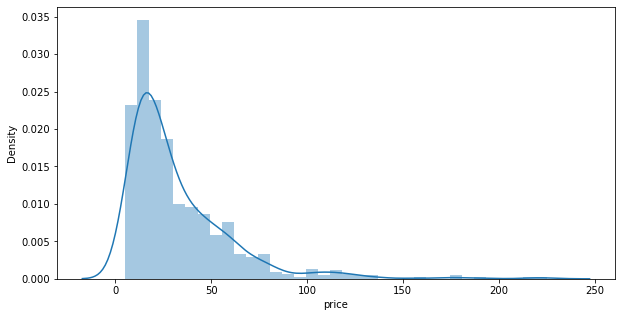

In [22]:
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(10,5))
sns.distplot(link2['price'])

### Méthode des 3 standard deviations :

In [23]:
print("Upper Control Limit",link2['price'].mean() + 3*link2['price'].std())
print("Lower Control Limit",link2['price'].mean() - 3*link2['price'].std())
std_up = link2.loc[link2["price"] > link2['price'].mean() + 3*link2['price'].std()]
std_low = link2.loc[link2["price"] < link2['price'].mean() - 3*link2['price'].std()]

print(std_up[["post_title", "price"]])
print(std_low[["post_title", "price"]])

Upper Control Limit 115.92471202187313
Lower Control Limit -50.9384375120692
                                            post_title  price
200     Champagne Egly-Ouriet Grand Cru Millésimé 2008  225.0
202     Champagne Egly-Ouriet Grand Cru Blanc de Noirs  126.5
219                               Cognac Frapin VIP XO  176.0
222  Cognac Frapin Château de Fontpinot 1989 20 Ans...  157.0
382  Domaine Des Croix Corton Charlemagne Grand Cru...  137.0
426     David Duband Charmes-Chambertin Grand Cru 2014  217.5
511  Domaine Weinbach Gewurztraminer Grand Cru Furs...  124.8
553                Camille Giroud Clos de Vougeot 2016  175.0
587  Coteaux Champenois Egly-Ouriet Ambonnay Rouge ...  191.3
603  Wemyss Malts Single Cask Scotch Whisky Choc 'n...  122.0
642             Champagne Gosset Célébris Vintage 2007  135.0
648  Domaine Clerget Echezeaux Grand Cru En Orveaux...  116.4
654  Domaine des Comtes Lafon Volnay 1er Cru Santen...  121.0
657  Domaine des Comtes Lafon Volnay 1er Cru Champa... 

### Methode de l'intérvalle interquartile (IQR) 

<AxesSubplot:xlabel='price'>

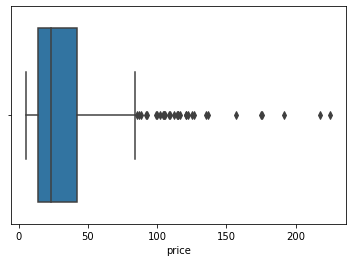

In [24]:
sns.boxplot(link2['price'])

In [25]:
percentile25 = link2['price'].quantile(0.25)
percentile75 = link2['price'].quantile(0.75)
iqr = percentile75 - percentile25
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

print(iqr)
print(upper_limit)
print(lower_limit)

28.075000000000003
84.28750000000001
-28.012500000000003


In [26]:
IQR_up = link2.loc[link2["price"] > upper_limit]
IQR_low = link2.loc[link2["price"] < lower_limit]

print(IQR_up[["post_title", "price"]])
print(IQR_low[["post_title", "price"]])

                                            post_title  price
64   Zind-Humbrecht Riesling Grand Cru Rangen De Th...  100.0
66   Zind-Humbrecht Pinot Gris Grand Cru Rangen De ...   88.4
200     Champagne Egly-Ouriet Grand Cru Millésimé 2008  225.0
202     Champagne Egly-Ouriet Grand Cru Blanc de Noirs  126.5
206  Champagne Larmandier-Bernier Grand Cru Les Che...   85.6
219                               Cognac Frapin VIP XO  176.0
220              Cognac Frapin Château de Fontpinot XO  108.5
222  Cognac Frapin Château de Fontpinot 1989 20 Ans...  157.0
223                          Cognac Frapin Cigar Blend  104.0
228  Château de Meursault Puligny-Montrachet 1er Cr...  109.6
381  Domaine Des Croix Corton Grand Cru Les Grèves ...  102.3
382  Domaine Des Croix Corton Charlemagne Grand Cru...  137.0
426     David Duband Charmes-Chambertin Grand Cru 2014  217.5
431  Domaine des Comtes Lafon Volnay 1er Cru Santen...  105.0
432  Domaine des Comtes Lafon Volnay 1er Cru Santen...  105.0
437  Cha

Selon les deux différentes méthodes de recherche des outliers nous n'obtenons pas la même liste.
On ensuite vérifier les prix un à un en ligne, à la main ou avec une méthode de scrapping.

# Web scrapping

Afin de récupérer les prix des produits outliers en ligne, on peut chercher sur le site wine-searcher.com. Ce site a une structure url principale identiques pour les recherches, la différence étant au milieu de l'adresse comportant la référence du produit recherché, chaque mot étant séparé par un tiret.
On peut donc reprendre les références des outliers et générer les adresses url des recherches afin d'aller récupérer les prix automatiquement en utilisant la librairie lxml et le module de scrapping requests.
Pour cela il faut entrer le xPath de l'élément recherché sur la page web pour récupérer son contenu.

Malheureusement après avoir effectué plusieurs requêtes, Wine-Searcher nous a bloqué et nos requêtes retournent maintenant une erreur 403, nous empêchant de rendre la tâche de vérification des prix outliers complètement automatique.

In [64]:
base = "https://www.wine-searcher.com/find/"
wineli = std_up["post_name"].replace("-", "+").to_list()
suffix = "/france"

for wine in wineli:
    stwine = str(wine)
    urls = base + stwine + suffix
    print(urls)

https://www.wine-searcher.com/find/champagne-egly-ouriet-grand-cru-millesime-2008/france
https://www.wine-searcher.com/find/champagne-egly-ouriet-grand-cru-brut-blanc-de-noirs/france
https://www.wine-searcher.com/find/cognac-frapin-vip-xo/france
https://www.wine-searcher.com/find/cognac-frapin-chateau-de-fontpinot-1989-20-ans/france
https://www.wine-searcher.com/find/domaine-des-croix-corton-charlemagne-grand-cru-2016/france
https://www.wine-searcher.com/find/david-duband-charmes-chambertin-grand-cru-2014/france
https://www.wine-searcher.com/find/domaine-weinbach-gewurztraminer-gc-furstentum-sgn-2010/france
https://www.wine-searcher.com/find/camille-giroud-clos-de-vougeot-2016/france
https://www.wine-searcher.com/find/coteaux-champenois-egly-ouriet-ambonnay-rouge-2016/france
https://www.wine-searcher.com/find/wemyss-malts-single-cask-scotch-whisky-choc-n-nut-pretzel-2001/france
https://www.wine-searcher.com/find/champagne-gosset-celebris-vintage-2007/france
https://www.wine-searcher.co

In [65]:
from lxml import html
import requests

In [67]:
page = requests.get('https://www.wine-searcher.com/find/egly+ouriet+grand+cru+brut+millesime+champagne+france/2008')
tree = html.fromstring(page.content)

print(page.status_code)

403


In [68]:
import requests

headers = {
    'accept': 'application/json',
    'X-CSRF-TOKEN': 'lO6ICvViwHmyLtx5A6BdoCTbdvnv7kw8MH4JNJyf',
}

response = requests.get('https://www.wine-searcher.com/find/egly+ouriet+grand+cru+brut+millesime+champagne+france/2008', headers=headers)
print(response.content)

b' {"appId": "PXK6S8okp3", "jsClientSrc": "/K6S8okp3/init.js", "firstPartyEnabled": true, "vid": "", "uuid": "82d03b84-b378-11ec-8a60-4e7852684b4b", "hostUrl": "/K6S8okp3/xhr", "blockScript": "/K6S8okp3/captcha/captcha.js?a=c&u=82d03b84-b378-11ec-8a60-4e7852684b4b&v=&m=0" } '


In [69]:
prices = tree.xpath('//*[@id="productInfo"]/div/ul[1]/li[1]/ul/li/ul/li[2]/span[1]')
print('Prices: ', prices)

Prices:  []
